In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print("food101" in datasets_list)
img_size = (224,224)

True


In [2]:
(train_data, test_data), ds_info = tfds.load(
    name= "food101",
    shuffle_files= True,
    split =["train", "validation"],
    download = True,
    data_dir = 'Data',
    as_supervised= True,
    with_info = True)

In [3]:
class_names = ds_info.features['label'].names

In [4]:
train_one_sample = train_data.take(1)
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [5]:
for img, lab in train_one_sample:
  print(img)
  print(lab)

tf.Tensor(
[[[131  86  55]
  [134  89  58]
  [137  92  61]
  ...
  [131  44   0]
  [135  49   2]
  [138  52   5]]

 [[134  89  58]
  [135  90  59]
  [135  90  59]
  ...
  [133  46   1]
  [134  48   1]
  [134  48   1]]

 [[136  91  60]
  [137  92  61]
  [139  94  63]
  ...
  [137  53   7]
  [135  51   5]
  [131  47   1]]

 ...

 [[130  23   3]
  [134  31  14]
  [132  36  24]
  ...
  [243 248 242]
  [243 248 242]
  [243 248 242]]

 [[128  22   0]
  [129  26   7]
  [124  28  14]
  ...
  [243 248 241]
  [242 247 240]
  [242 247 240]]

 [[132  26   2]
  [133  31   9]
  [126  29  13]
  ...
  [242 247 240]
  [242 247 240]
  [242 247 240]]], shape=(512, 512, 3), dtype=uint8)
tf.Tensor(31, shape=(), dtype=int64)


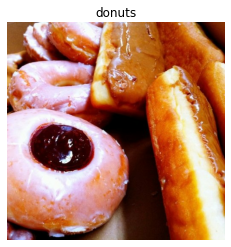

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.imshow(img.numpy())
plt.title(class_names[lab.numpy()])
plt.axis('off')
plt.show()

In [7]:
def preprocess_img(img, label):
  img = tf.image.resize(img, size = img_size)
  img = tf.cast(img, dtype = tf.float32)
  return img, label

In [8]:
test_data
#test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

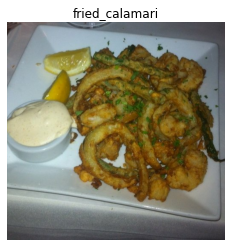

In [9]:
for img, lab in train_data.take(1):
  plt.imshow(img.numpy()/255.)
  plt.title(class_names[lab.numpy()])
  plt.axis('off')
  plt.show()

In [10]:
train_data = train_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size=10000).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [11]:
train_data

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

In [12]:
import datetime
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16")

log_dir = "Tensorboard/Full-Data/EfficientNet/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
callbacks = [
             #tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10 ** (epoch / 20), verbose=0),
             tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7),
              tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              patience=5,
                                              verbose=0),
              tf.keras.callbacks.ModelCheckpoint(
                  filepath='Models_checkpoint_EfficientNet_Full_Data/model_ep_{epoch:02d}_val_accuracy_{val_accuracy:.4f}.ckpt',
                  # file path format: "Model_checkpoint_Classification_2/cp-{epoch:02d}-{val_loss:.02f}.ckpt"
                  save_weights_only=True,
                  verbose=0),
            tf.keras.callbacks.TensorBoard(log_dir=log_dir)
                ]

mixed_precision.global_policy()

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla K80, compute capability 3.7
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla K80, compute capability 3.7
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


<Policy "mixed_float16">

In [13]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model 
inputs = layers.Input(shape=img_size+(3,), name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = preprocessing.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class 
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [14]:
history_101_food_classes_feature_extract = model.fit(train_data, 
                                                     epochs=3,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=callbacks)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/3
2368/2368 [==============================] - 312s 114ms/step - loss: 1.8216 - accuracy: 0.5585 - val_loss: 1.2413 - val_accuracy: 0.6674 - lr: 0.0010
Epoch 2/3
2368/2368 [==============================] - 270s 106ms/step - loss: 1.2943 - accuracy: 0.6660 - val_loss: 1.1233 - val_accuracy: 0.6997 - lr: 0.0010
Epoch 3/3
2368/2368 [==============================] - 273s 107ms/step - loss: 1.1442 - accuracy: 0.7011 - val_loss: 1.0931 - val_accuracy: 0.7050 - lr: 0.0010


In [15]:
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model #[1.0830175876617432, 0.7089108824729919]

790/790 [==============================] - 84s 107ms/step - loss: 1.0830 - accuracy: 0.7089


[1.0830175876617432, 0.7089108824729919]

In [17]:
save_dir = "07_efficientnetb0_feature_extract_model_mixed_precision"
model.save(save_dir)

INFO:tensorflow:Assets written to: 07_efficientnetb0_feature_extract_model_mixed_precision/assets


INFO:tensorflow:Assets written to: 07_efficientnetb0_feature_extract_model_mixed_precision/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [18]:
loaded_saved_model = tf.keras.models.load_model(save_dir)

In [19]:
results_loaded_saved_model = loaded_saved_model.evaluate(test_data)
results_loaded_saved_model #[1.0830169916152954, 0.7089108824729919]

790/790 [==============================] - 79s 98ms/step - loss: 1.0830 - accuracy: 0.7089


[1.0830169916152954, 0.7089108824729919]

In [20]:
from google.colab import files
import os

dir_to_zip = '07_efficientnetb0_feature_extract_model_mixed_precision' #@param {type: "string"}
output_filename = '07_efficientnetb0_feature_extract_model_mixed_precision.zip' #@param {type: "string"}
delete_dir_after_download = "No"  #@param ['Yes', 'No']

os.system( "zip -r {} {}".format( output_filename , dir_to_zip ) )

if delete_dir_after_download == "Yes":
    os.system( "rm -r {}".format( dir_to_zip ) )

files.download( output_filename )

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
from google.colab import files
import os

dir_to_zip = 'Models_checkpoint_EfficientNet_Full_Data' #@param {type: "string"}
output_filename = 'Models_checkpoint_EfficientNet_Full_Data_Feature_Extraction.zip' #@param {type: "string"}
delete_dir_after_download = "No"  #@param ['Yes', 'No']

os.system( "zip -r {} {}".format( output_filename , dir_to_zip ) )

if delete_dir_after_download == "Yes":
    os.system( "rm -r {}".format( dir_to_zip ) )

files.download( output_filename )

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
from google.colab import files
import os

dir_to_zip = 'Tensorboard' #@param {type: "string"}
output_filename = 'Tensorboard.zip' #@param {type: "string"}
delete_dir_after_download = "No"  #@param ['Yes', 'No']

os.system( "zip -r {} {}".format( output_filename , dir_to_zip ) )

if delete_dir_after_download == "Yes":
    os.system( "rm -r {}".format( dir_to_zip ) )

files.download( output_filename )

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>